In [1]:
import os
import shutil
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
!pip install nltk==3.7
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
pd.set_option("display.max_colwidth",None)
from google.cloud import storage
from pyspark.sql import Row

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
tw_df=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kishorkumarreddy/Final_Project-100millionFilterHashtag')
#path: msca-bdp-students-bucket/shared_data/kishorkumarreddy/Final_Project-100millionFilterHashtag

23/03/10 18:28:32 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
tw_df.createOrReplaceTempView("tw_df")
query = '''select tweet_text as text,
retweeted_status.id as rt_object_id,
user.description as desc
from tw_df'''
tw_Q4 = spark.sql(query)

In [7]:
tw_Q4 = tw_Q4.sample(0.025)

In [8]:
tw_Q4 = tw_Q4.withColumn("org",when(col("desc").rlike('.*government.*|.*Government.*|.*minister.*|.*Minister.*|.*gov.*'),"gov")
                         .when(col("desc").rlike('.*University.*|.*university.*|.*school.*|.*School.*'),"edu")
                         .when(col("desc").rlike('.*News.*|.*news.*|.*Media.*|.*media.*'),"news")
                         .when(col("desc").rlike('.*nonprofit.*|.*Nonprofit.*|.*NGO.*|.*aid.*'),"ngo")
                         .when(col("desc").rlike('.*influencer.*|.*Influencer.*'),"influencer").otherwise('Others'))
tw_df1 = tw_Q4.withColumn("tweet_type",when(col("rt_object_id").isNull() != True,"retweet").otherwise("tweet"))
tw_df1.show()

+--------------------+-------------------+--------------------+------+----------+
|                text|       rt_object_id|                desc|   org|tweet_type|
+--------------------+-------------------+--------------------+------+----------+
|massive protests ...|               null|Follow http://ind...|  news|     tweet|
|real story about ...|1571340634820325377|Nationalist, हिंद...|Others|   retweet|
|real story about ...|1571340634820325377|    Savage/sweetness|Others|   retweet|
|she sucked her be...|1570601230287900682|                null|Others|   retweet|
|#justice_for_maga...|1570014495350886401|                null|Others|   retweet|
|#justice_for_maga...|1570014572572180480|                null|Others|   retweet|
|#justice_for_maga...|1570014309564174340|                null|Others|   retweet|
|#justice_for_maga...|1570014207701286912|      I am a student|Others|   retweet|
|#justice_for_maga...|1570013849767804930|                null|Others|   retweet|
|@pennlaw @dorot

In [9]:
tw_df1 = tw_df1.filter(col('tweet_type') == 'tweet')
tw_df1.show()

+--------------------+------------+-------------------------+------+----------+
|                text|rt_object_id|                     desc|   org|tweet_type|
+--------------------+------------+-------------------------+------+----------+
|massive protests ...|        null|     Follow http://ind...|  news|     tweet|
|@pennlaw @dorothy...|        null|       یک سینیور اورتینکر|Others|     tweet|
|@cnnbrk in front ...|        null|스티와 아미 💜We are t...|Others|     tweet|
|my boobs were so ...|        null|     24 yr ✰ bisex (no...|Others|     tweet|
|it's that time of...|        null|     Official Twitter ...|Others|     tweet|
|@harvard we need ...|        null|                     null|Others|     tweet|
|freaky teen eatin...|        null|     main @pyttingz de...|Others|     tweet|
|@harvard in front...|        null|     هرچی که توی مغزمه...|Others|     tweet|
|@eunoiavirago_ be...|        null|     یک عدد دانشجو که ...|Others|     tweet|
|the #everyonesinv...|        null|     A real

In [10]:
tw_df2 = tw_df1.select('org')
tw_df.show()

+-----------+--------------------+------------------+--------------------+--------------------+--------------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+--------------------+-------------------+--------------------+-----------------------+--------------------+-----------+-------------+---------+---------------+--------------------+--------------------+--------------------+-------------+---------+--------------------+--------------------+---------------------+--------------------+
|coordinates|          created_at|display_text_range|            entities|   extended_entities|      extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_r

In [11]:
tw_df1 = tw_df1.select('text',substring('text',1,100)).withColumnRenamed("substring(text, 1, 100)","tweet_text")

In [12]:
tw_df1.printSchema()

root
 |-- text: string (nullable = true)
 |-- tweet_text: string (nullable = true)



In [13]:
body_text = tw_df1.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
row = Row('text')
text_df=body_text.map(row).zipWithIndex().toDF(['tweet_text','id'])
text_df.limit(5)

tweet_text,id
{what’s the worst...,449
{study mbbs in pm...,450
{thank you!!! #co...,451
{minnesota studen...,452
{chinese ambassad...,453


In [14]:
tokens = body_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [15]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
#Drop records with no tokens

In [16]:
df_tokens=df_tokens.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
tw_df2=tw_df2.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

df_tokens = df_tokens.join(tw_df2, on=["row_index"]).drop("row_index")
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [17]:
# countvectorize
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens) 

23/03/10 18:30:53 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:30:53 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:31:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:31:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:31:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [18]:
# fit MinHashLSH for hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize) #.cache()

In [19]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left') #.cache()

# Tweet Uniqueness Graph Based on Jaccard Similarity (0.3)

In [20]:
jaccard_distance = 0.3
df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),col("datasetA.org").alias('org'),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B')) 
df_dups_txt_30 = df_dups_text_30
df_dups_text_30.limit(20).toPandas().sort_values('distCol',ascending=False)

23/03/10 18:31:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:31:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:31:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:31:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:32:44 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,distCol,org,id_A,id_B,text_A,text_B
0,0.285714,news,767,2933,"(@teacherinkinder @donorschoose @amazon hi, hello, howdy! happy #sundayvibes it’s #backtoschool &amp;,)","(@mrs_al_13 @donorschoose @amazon hi, hello, howdy! happy #sundayvibes it’s #backtoschool &amp; my cl,)"
2,0.230769,Others,620,621,"(@joebiden ⚠️urgent⚠️\nthe students at #sharif_university, first ranking university in iran, are trapp,)","(@kamalaharris ⚠️urgent⚠️\nthe students at #sharif_university, first ranking university in iran, are t,)"
1,0.166667,Others,3320,8619,"(@janethlovsbooks @amazon i'm a hs #specialeducation teacher working with cognitively impaired studen,)","(@techmidschteach @amazon i'm a hs #specialeducation teacher working with cognitively impaired studen,)"
11,0.000000,Others,134,3212,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
18,0.000000,Others,1113,8711,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
17,0.000000,Others,1113,3248,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
16,0.000000,Others,1113,3212,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
15,0.000000,Others,1113,1552,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
14,0.000000,Others,1113,1502,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
13,0.000000,Others,134,8711,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"


In [21]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques = records - dups_30

print ('Total records: ', records)
print ('Duplicate Tweets based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique Tweets based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

23/03/10 18:33:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:33:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:34:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:34:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:34:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Total records:  8807
Duplicate Tweets based on { 0.3 } jaccard distance:  577
Unique Tweets based on { 0.3 } jaccard distance:  0.3 :  8230


In [22]:
df_dups_text_30.createOrReplaceTempView("tw_df")

In [ ]:
dup_df = spark.sql('select org,count(*) from tw_df group by org').toPandas()
dup_df

23/03/10 18:36:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:36:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:36:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:36:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,org,count(1)
0,news,11
1,Others,1584
2,edu,128
3,ngo,1
4,gov,26
5,influencer,13


In [ ]:
df_hashed_text.createOrReplaceTempView("tw_df")

In [ ]:
all_df = spark.sql('select org,count(*) from tw_df group by org').toPandas()

23/03/10 18:37:56 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:37:56 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:38:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:38:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:38:59 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [ ]:
all_df.head()

,org,count(1)
0,news,530
1,gov,103
2,edu,1395
3,influencer,16
4,Others,6702


In [ ]:
dup_df.head()

,org,count(1)
0,news,11
1,Others,1584
2,edu,128
3,ngo,1
4,gov,26


In [ ]:
dup_df.sort_values(by='org',inplace=True)
all_df.drop(3,inplace=True)
all_df

,org,count(1)
0,news,530
1,gov,103
2,edu,1395
4,Others,6702
5,ngo,61


In [ ]:
dup_df

,org,count(1)
1,Others,1584
2,edu,128
4,gov,26
5,influencer,13
0,news,11
3,ngo,1


In [ ]:
all_df.sort_values(by='org',inplace=True)

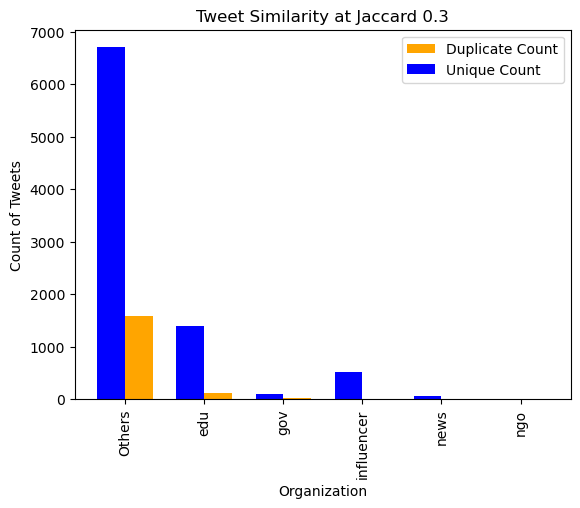

In [ ]:
fig, ax = plt.subplots()
index = np.arange(len(dup_df['org']))
index2 = np.arange(len(all_df['org']))

bar_width = 0.35
opacity = 0.8

ax.bar(index, dup_df['count(1)'], color='orange', align='edge', width=bar_width, label = 'Duplicate Count')
ax.bar(index2, all_df['count(1)'], color='blue', align='edge', width=-bar_width,label = 'Unique Count')

# Assign the tick labels
ax.set_xticks(index)
ax.set_xticklabels(dup_df['org'], rotation=90)
plt.title('Tweet Similarity at Jaccard 0.3')
plt.xlabel('Organization')
plt.ylabel('Count of Tweets')
plt.legend()
plt.show()

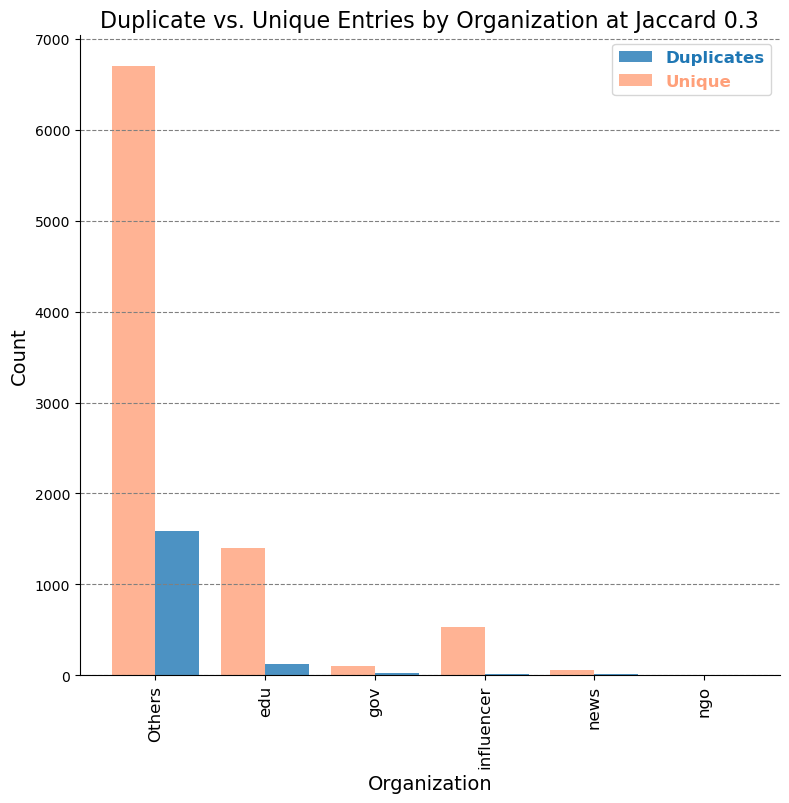

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom colors
bar_colors = ['#1F77B4', '#FFA07A']

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 8))

# Define bar width and opacity
bar_width = 0.4
opacity = 0.8

# Define index arrays for each set of bars
index = np.arange(len(dup_df['org']))
index2 = np.arange(len(all_df['org']))

# Create the two sets of vertical bars
ax.bar(index, dup_df['count(1)'], color=bar_colors[0], align='edge', width=bar_width, alpha=opacity, label='Duplicates')
ax.bar(index2, all_df['count(1)'], color=bar_colors[1], align='edge', width=-bar_width, alpha=opacity, label='Unique')

# Set the tick labels and axis limits
ax.set_xticks(index)
ax.set_xticklabels(dup_df['org'], fontsize=12, rotation=90)
ax.set_ylim(bottom=0)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Organization', fontsize=14)

# Add a title and adjust the subplot spacing
ax.set_title('Duplicate vs. Unique Entries by Organization at Jaccard 0.3', fontsize=16)
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)

# Add a legend with custom formatting
legend = ax.legend(loc='upper right', fontsize=12)
for i, text in enumerate(legend.get_texts()):
    plt.setp(text, color=bar_colors[i], weight='bold')

# Remove spines and set a grid
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='gray', linestyle='dashed')

# Show the plot
plt.show()

In [ ]:
all_df.sort_values(by='org',inplace=True)

# Tweet Uniqueness Graph Based on Jaccard Similarity (0.5)

In [ ]:
jaccard_distance = 0.5
df_dups_text_50 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),col("datasetA.org").alias('org'),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B')) 
df_dups_txt_50 = df_dups_text_50
df_dups_text_50.limit(20).toPandas().sort_values('distCol',ascending=False)

23/03/10 18:39:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:39:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:39:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:39:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:40:08 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,distCol,org,id_A,id_B,text_A,text_B
1,0.470588,Others,1374,2286,"(big snowman: lined notebook by daisy ford design https://t.co/hyaailolb2 via @amazon #notebook #scho,)","(blue cat: lined notebook by daisy ford design https://t.co/54jqdvxaom via @amazon #notebook #diary #,)"
3,0.357143,Others,573,620,"(@antonioguterres ⚠️urgent⚠️\nthe students at #sharif_university, first ranking university in iran, ar,)","(@joebiden ⚠️urgent⚠️\nthe students at #sharif_university, first ranking university in iran, are trapp,)"
4,0.307692,Others,573,621,"(@antonioguterres ⚠️urgent⚠️\nthe students at #sharif_university, first ranking university in iran, ar,)","(@kamalaharris ⚠️urgent⚠️\nthe students at #sharif_university, first ranking university in iran, are t,)"
0,0.285714,news,767,2933,"(@teacherinkinder @donorschoose @amazon hi, hello, howdy! happy #sundayvibes it’s #backtoschool &amp;,)","(@mrs_al_13 @donorschoose @amazon hi, hello, howdy! happy #sundayvibes it’s #backtoschool &amp; my cl,)"
5,0.230769,Others,620,621,"(@joebiden ⚠️urgent⚠️\nthe students at #sharif_university, first ranking university in iran, are trapp,)","(@kamalaharris ⚠️urgent⚠️\nthe students at #sharif_university, first ranking university in iran, are t,)"
2,0.166667,Others,3320,8619,"(@janethlovsbooks @amazon i'm a hs #specialeducation teacher working with cognitively impaired studen,)","(@techmidschteach @amazon i'm a hs #specialeducation teacher working with cognitively impaired studen,)"
13,0.000000,Others,134,1552,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
18,0.000000,Others,1113,1552,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
17,0.000000,Others,1113,1502,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"
16,0.000000,Others,134,8711,"(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)","(time to return to learn! enter the $100 amazon gift card giveaway! #btevents #backtoschool https:/,)"


In [ ]:
records = df_hashed_text.count()
dups_50 = df_dups_text_50.select('id_A').distinct().count()
uniques = records - dups_50

print ('Total records: ', records)
print ('Duplicate Tweets based on {', jaccard_distance, '} jaccard distance: ', dups_50)
print ('Unique Tweets based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

23/03/10 18:40:36 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:40:36 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:41:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:41:38 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:41:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Total records:  8807
Duplicate Tweets based on { 0.5 } jaccard distance:  858
Unique Tweets based on { 0.5 } jaccard distance:  0.5 :  7949


In [ ]:
df_dups_text_50.createOrReplaceTempView("tw_df")

In [ ]:
dup_df_5 = spark.sql('select org,count(*) from tw_df group by org').toPandas()
dup_df_5

23/03/10 18:43:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:43:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:43:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:43:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:44:20 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,org,count(1)
0,news,14
1,Others,3117
2,edu,214
3,ngo,1
4,gov,37
5,influencer,13


In [ ]:
df_hashed_text.createOrReplaceTempView("tw_df")

In [ ]:
all_df_5 = spark.sql('select org,count(*) from tw_df group by org').toPandas()

23/03/10 18:44:48 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:44:48 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:45:50 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:45:50 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:45:53 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [ ]:
all_df_5.head()

,org,count(1)
0,news,530
1,gov,103
2,edu,1395
3,influencer,16
4,Others,6702


In [ ]:
dup_df_5.sort_values(by='org',inplace=True)
all_df_5.drop(3,inplace=True)
all_df_5

,org,count(1)
0,news,530
1,gov,103
2,edu,1395
4,Others,6702
5,ngo,61


In [ ]:
dup_df_5

,org,count(1)
1,Others,3117
2,edu,214
4,gov,37
5,influencer,13
0,news,14
3,ngo,1


In [ ]:
all_df_5.sort_values(by='org',inplace=True)

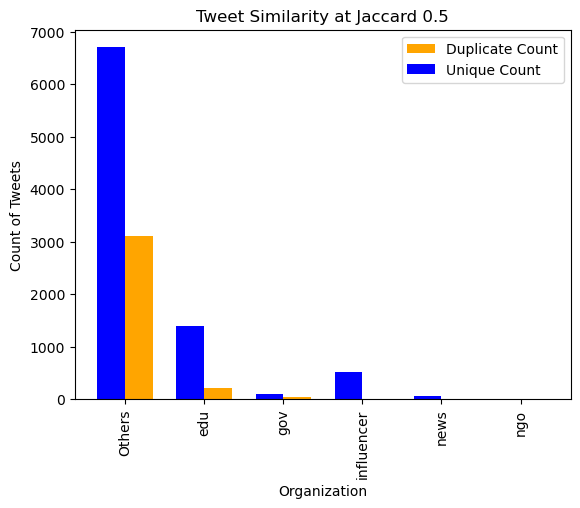

In [ ]:
fig, ax = plt.subplots()
index = np.arange(len(dup_df_5['org']))
index2 = np.arange(len(all_df_5['org']))

bar_width = 0.35
opacity = 0.8

ax.bar(index, dup_df_5['count(1)'], color='orange', align='edge', width=bar_width, label = 'Duplicate Count')
ax.bar(index2, all_df_5['count(1)'], color='blue', align='edge', width=-bar_width,label = 'Unique Count')

# Assign the tick labels
ax.set_xticks(index)
ax.set_xticklabels(dup_df['org'], rotation=90)

plt.xlabel('Organization')
plt.title('Tweet Similarity at Jaccard 0.5')
plt.ylabel('Count of Tweets')
plt.legend()
plt.show()

# Tweet Uniqueness Graph Based on Jaccard Similarity (0.7)

In [ ]:
jaccard_distance = 0.7
df_dups_text_70 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),col("datasetA.org").alias('org'),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B')) 
df_dups_txt_70 = df_dups_text_70
df_dups_text_70.limit(20).toPandas().sort_values('distCol',ascending=False)

23/03/10 18:45:58 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:45:58 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:45:58 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:45:58 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:47:02 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,distCol,org,id_A,id_B,text_A,text_B
2,0.684211,Others,1374,2811,"(big snowman: lined notebook by daisy ford design https://t.co/hyaailolb2 via @amazon #notebook #scho,)","(happiest season: christmas notebooks by daisy ford design https://t.co/457fi08d26 via @amazon #noteb,)"
4,0.684211,Others,2286,2811,"(blue cat: lined notebook by daisy ford design https://t.co/54jqdvxaom via @amazon #notebook #diary #,)","(happiest season: christmas notebooks by daisy ford design https://t.co/457fi08d26 via @amazon #noteb,)"
5,0.684211,Others,2286,3240,"(blue cat: lined notebook by daisy ford design https://t.co/54jqdvxaom via @amazon #notebook #diary #,)","(blue toy train: lined notebook https://t.co/0affnq1pvo via @amazon #notebook #school #college #colle,)"
10,0.647059,Others,3240,3958,"(blue toy train: lined notebook https://t.co/0affnq1pvo via @amazon #notebook #school #college #colle,)","(paris diary: lined journal https://t.co/kzz0dizkhi via @amazon #notebook #journal #school #college #,)"
8,0.647059,Others,3105,3958,"(santa claus on skates: lined notebook https://t.co/qs4f7x4uiv via @amazon #notebook #school #college,)","(paris diary: lined journal https://t.co/kzz0dizkhi via @amazon #notebook #journal #school #college #,)"
12,0.647059,Others,3847,3958,"(honey bee: lined notebook https://t.co/9qwplkfvom via @amazon #notebook #school #college #home #writ,)","(paris diary: lined journal https://t.co/kzz0dizkhi via @amazon #notebook #journal #school #college #,)"
3,0.615385,Others,1867,4165,"(@d900gt @amazon awesome 😁😁 @d900gt\n\n#theschooljourney #school #book #bookers,)","(@d900gt @amazon oh wow, nice!! @d900gt \n\n#theschooljourney #school #book #bookers #deepikapadukone,)"
6,0.588235,Others,3105,3240,"(santa claus on skates: lined notebook https://t.co/qs4f7x4uiv via @amazon #notebook #school #college,)","(blue toy train: lined notebook https://t.co/0affnq1pvo via @amazon #notebook #school #college #colle,)"
7,0.588235,Others,3105,3847,"(santa claus on skates: lined notebook https://t.co/qs4f7x4uiv via @amazon #notebook #school #college,)","(honey bee: lined notebook https://t.co/9qwplkfvom via @amazon #notebook #school #college #home #writ,)"
9,0.588235,Others,3240,3847,"(blue toy train: lined notebook https://t.co/0affnq1pvo via @amazon #notebook #school #college #colle,)","(honey bee: lined notebook https://t.co/9qwplkfvom via @amazon #notebook #school #college #home #writ,)"


In [ ]:
records = df_hashed_text.count()
dups_70 = df_dups_text_70.select('id_A').distinct().count()
uniques = records - dups_70

print ('Total records: ', records)
print ('Duplicate Tweets based on {', jaccard_distance, '} jaccard distance: ', dups_70)
print ('Unique Tweets based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

23/03/10 18:47:32 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:47:32 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:48:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:48:34 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:48:36 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Total records:  8807
Duplicate Tweets based on { 0.7 } jaccard distance:  1303
Unique Tweets based on { 0.7 } jaccard distance:  0.7 :  7504


In [ ]:
df_dups_text_70.createOrReplaceTempView("tw_df")

In [ ]:
dup_df = spark.sql('select org,count(*) from tw_df group by org').toPandas()
dup_df

23/03/10 18:50:08 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:50:08 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:50:08 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:50:08 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:51:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

,org,count(1)
0,news,45
1,Others,6684
2,edu,425
3,ngo,6
4,gov,48
5,influencer,13


In [ ]:
df_hashed_text.createOrReplaceTempView("tw_df")

In [ ]:
all_df = spark.sql('select org,count(*) from tw_df group by org').toPandas()

23/03/10 18:51:37 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:51:37 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:52:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:52:39 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/10 18:52:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

In [ ]:
all_df.head()

,org,count(1)
0,news,530
1,gov,103
2,edu,1395
3,influencer,16
4,Others,6702


In [ ]:
dup_df.sort_values(by='org',inplace=True)
all_df.drop(3,inplace=True)
all_df

,org,count(1)
0,news,530
1,gov,103
2,edu,1395
4,Others,6702
5,ngo,61


In [ ]:
dup_df

,org,count(1)
1,Others,6684
2,edu,425
4,gov,48
5,influencer,13
0,news,45
3,ngo,6


In [ ]:
all_df.sort_values(by='org',inplace=True)

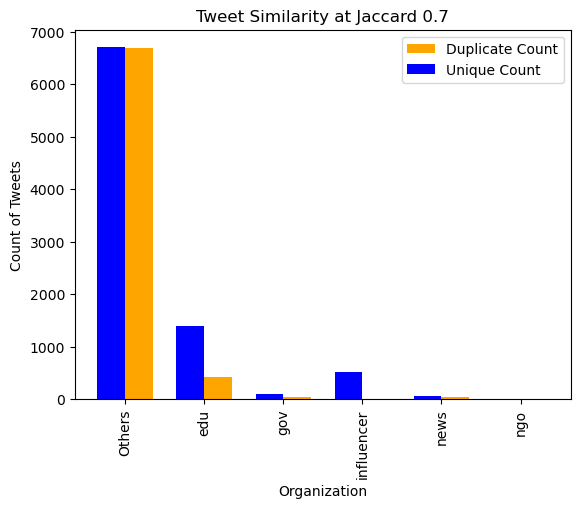

In [ ]:
fig, ax = plt.subplots()
index = np.arange(len(dup_df['org']))
index2 = np.arange(len(all_df['org']))

bar_width = 0.35
opacity = 0.8

ax.bar(index, dup_df['count(1)'], color='orange', align='edge', width=bar_width, label = 'Duplicate Count')
ax.bar(index2, all_df['count(1)'], color='blue', align='edge', width=-bar_width,label = 'Unique Count')

# Assign the tick labels
ax.set_xticks(index)
ax.set_xticklabels(dup_df['org'], rotation=90)
plt.title('Tweet Similarity at Jaccard 0.7')
plt.xlabel('Organization')
plt.ylabel('Count of Tweets')
plt.legend()
plt.show()

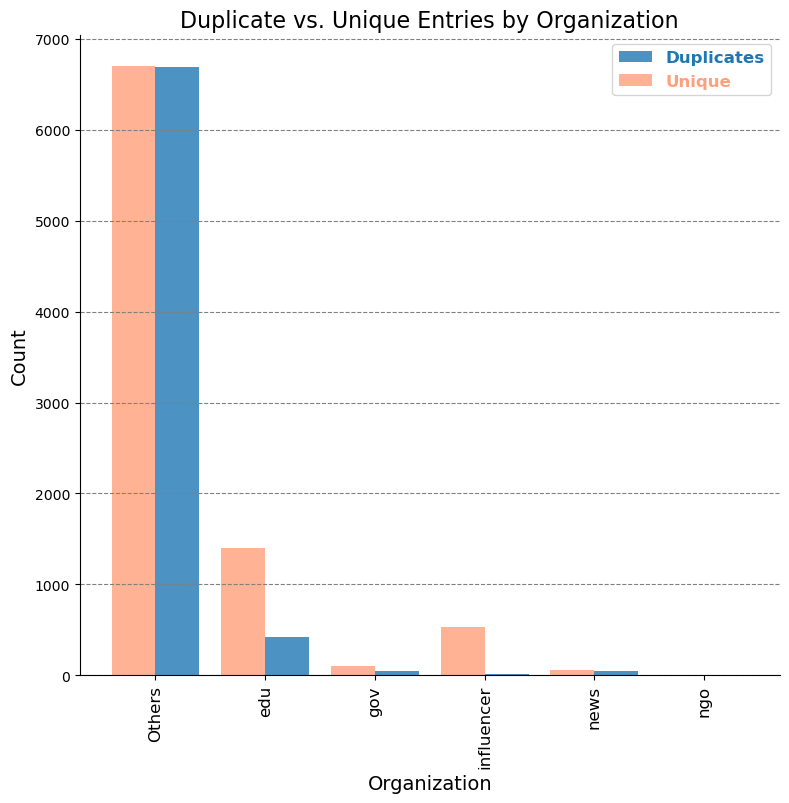

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom colors
bar_colors = ['#1F77B4', '#FFA07A']

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 8))

# Define bar width and opacity
bar_width = 0.4
opacity = 0.8

# Define index arrays for each set of bars
index = np.arange(len(dup_df['org']))
index2 = np.arange(len(all_df['org']))

# Create the two sets of vertical bars
ax.bar(index, dup_df['count(1)'], color=bar_colors[0], align='edge', width=bar_width, alpha=opacity, label='Duplicates')
ax.bar(index2, all_df['count(1)'], color=bar_colors[1], align='edge', width=-bar_width, alpha=opacity, label='Unique')

# Set the tick labels and axis limits
ax.set_xticks(index)
ax.set_xticklabels(dup_df['org'], fontsize=12, rotation=90)
ax.set_ylim(bottom=0)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Organization', fontsize=14)

# Add a title and adjust the subplot spacing
ax.set_title('Duplicate vs. Unique Entries by Organization', fontsize=16)
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)

# Add a legend with custom formatting
legend = ax.legend(loc='upper right', fontsize=12)
for i, text in enumerate(legend.get_texts()):
    plt.setp(text, color=bar_colors[i], weight='bold')

# Remove spines and set a grid
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='gray', linestyle='dashed')

# Show the plot
plt.show()